In [2]:
import torch, random
import numpy as np
import torch.nn.functional as F
from tqdm.auto import tqdm
from IPython.display import Audio
from matplotlib import pyplot as plt
from diffusers import DiffusionPipeline, AudioPipelineOutput
from torchaudio import transforms as AT
from torchvision import transforms as IT

import torchaudio

from transformers import ClapProcessor, ClapModel
from torch.optim import AdamW, Adam
from torch.utils.data import DataLoader, Dataset

from diffusers import MusicLDMPipeline


## Load MusicCAPS

In [2]:
from datasets import load_dataset

ds = load_dataset('google/MusicCaps', split='train')

import subprocess
import os
from pathlib import Path

def download_clip(
    video_identifier,
    output_filename,
    start_time,
    end_time,
    tmp_dir='/tmp/musiccaps/',
    num_attempts=5,
    url_base='https://www.youtube.com/watch?v='
):
    status = False

    command = f"""
        yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "{output_filename}" --download-sections "*{start_time}-{end_time}" {url_base}{video_identifier}
    """.strip()

    attempts = 0
    while True:
        try:
            output = subprocess.check_output(command, shell=True,
                                                stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as err:
            attempts += 1
            if attempts == num_attempts:
                return status, err.output
        else:
            break

    # Check if the video was successfully saved.
    status = os.path.exists(output_filename)
    return status, 'Downloaded'


from datasets import Audio as audiod

samples_to_load = 5521      # How many samples to load
cores = 4                 # How many processes to use for the loading
sampling_rate = 44100     # Sampling rate for the audio, keep in 44100
writer_batch_size = 1000  # How many examples to keep in memory per worker. Reduce if OOM.
data_dir = "/srv/nfs-data/sisko/matteoc/music/music_data_caps" # Where to save the data

# Just select some samples 
ds = ds.select(range(samples_to_load))

# Create directory where data will be saved
data_dir = Path(data_dir)
data_dir.mkdir(exist_ok=True, parents=True)

def process(example):
    outfile_path = str(data_dir / f"{example['ytid']}.wav")
    status = True
    if not os.path.exists(outfile_path):
        status = False
        status, log = download_clip(
            example['ytid'],
            outfile_path,
            example['start_s'],
            example['end_s'],
        )

    example['audio'] = outfile_path
    example['download_status'] = status
    return example


ds = ds.map(
        process,
        num_proc=cores,
        writer_batch_size=writer_batch_size,
        keep_in_memory=False
    ).cast_column('audio', audiod(sampling_rate=sampling_rate))

In [3]:
song_idx = 3799
audio_array = ds[song_idx]["audio"]["array"]
audio_caption = ds[song_idx]["caption"]
sample_rate_dataset = ds[song_idx]["audio"]["sampling_rate"]
print("Audio array shape:", audio_array.shape)
print("Audio caption:", audio_caption)
print("Sample rate:", sample_rate_dataset)
display(Audio(audio_array[0:10*sample_rate_dataset], rate=sample_rate_dataset))

Audio array shape: (880832,)
Audio caption: The low quality recording features a classical song that consists of a brass solo melody played over sustained brass melody and short flute lick. It sounds emotional, joyful and the recording is noisy.
Sample rate: 44100


In [4]:
ds[song_idx]

{'ytid': 'dbBlYyaFKTQ',
 'start_s': 30,
 'end_s': 40,
 'audioset_positive_labels': '/m/01kcd,/m/0319l,/m/05pd6,/m/07c6l,/m/07gql',
 'aspect_list': "['low quality', 'noisy', 'classical', 'flute lick', 'brass solo melody', 'sustained brass melody', 'emotional', 'joyful']",
 'caption': 'The low quality recording features a classical song that consists of a brass solo melody played over sustained brass melody and short flute lick. It sounds emotional, joyful and the recording is noisy.',
 'author_id': 4,
 'is_balanced_subset': False,
 'is_audioset_eval': False,
 'audio': {'path': '/srv/nfs-data/sisko/matteoc/music/music_data_caps/dbBlYyaFKTQ.wav',
  'array': array([-0.00827911, -0.01138475, -0.01273868, ..., -0.01942613,
         -0.01393065,  0.        ]),
  'sampling_rate': 44100},
 'download_status': True}

## Build Dataset

In [ ]:
def pad_or_truncate_audio(audio, max_len_samples):
    """Pads the audio to the max length with zeros or truncates if necessary."""
    audio = torch.tensor(audio).float()
    if len(audio) < max_len_samples:
        padding = max_len_samples - len(audio)
        audio = F.pad(audio, (0, padding), 'constant', 0)
    else:
        audio = audio[:max_len_samples]
    return audio

max_len_sec = 10
# audio_tensor = torch.zeros(samples_to_load, sample_rate_dataset*max_len_sec)
audio_tensor = []
for elem in tqdm(range(len(ds))):
    try:
        audio_select = ds[elem]["audio"]["array"]
    except FileNotFoundError:
        continue
    audio_padded = pad_or_truncate_audio(audio_select, sample_rate_dataset*max_len_sec)
    # audio_tensor[elem] = audio_padded
    audio_tensor.append(audio_padded)
audio_tensor = torch.stack(audio_tensor, dim=0)




In [13]:
audio_tensor.shape

torch.Size([5402, 441000])

In [3]:
# torch.save(audio_tensor, '/srv/nfs-data/sisko/matteoc/music/music_data_caps_audio.pt')
audio_tensor = torch.load('/srv/nfs-data/sisko/matteoc/music/music_data_caps_audio.pt')

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

repo_id = "ucsd-reach/musicldm"
musicldm_pipe = MusicLDMPipeline.from_pretrained(repo_id, torch_dtype=torch.float32)
device = "cuda:4" if torch.cuda.is_available() else "cpu"
musicldm_pipe = musicldm_pipe.to(device)

clap_model_id = "laion/larger_clap_music_and_speech"
clap_model = ClapModel.from_pretrained(clap_model_id).to(device)
clap_process = ClapProcessor.from_pretrained(clap_model_id)

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.18it/s]


In [5]:
class AudioDataset(Dataset):
    def __init__(self, dataset, sample_rate_dataset=44100, new_sr=48000):
        self.dataset = dataset
        # self.processor = ClapProcessor.from_pretrained('laion/clap-htsat-unfused')
        self.resampler = torchaudio.transforms.Resample(orig_freq=sample_rate_dataset, new_freq=new_sr)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        audio_array = self.dataset[idx]
        audio_res = self.resampler(audio_array)
        inputs = clap_process(audios=audio_res, return_tensors="pt", sampling_rate=48000)
        
        return inputs['input_features'][0]
    
    


In [6]:
audio_dataset = AudioDataset(audio_tensor)

train_size = int(0.8 * len(audio_dataset))
val_size = len(audio_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(audio_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)



In [16]:
for batch in val_dataloader:
    batch = batch.to(device)
    encoded = musicldm_pipe.vae.encode(batch)
    latents_real = 0.18215 * encoded.latent_dist.mean
    audio_features = clap_model.get_audio_features(batch)
    del batch
    print(latents_real.shape)
    print(audio_features.shape)
    break

torch.Size([8, 8, 250, 16])
torch.Size([8, 512])


## Training

In [7]:
num_epochs = 10  
lr = 1e-5  
grad_accumulation_steps = 2  

optimizer = torch.optim.AdamW(musicldm_pipe.unet.parameters(), lr=lr)

train_losses = []


  0%|          | 0/271 [00:00<?, ?it/s]/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 271/271 [03:52<00:00,  1.16it/s]

Epoch 0 average loss: 0.045947700749216704



100%|██████████| 271/271 [03:53<00:00,  1.16it/s]

Epoch 1 average loss: 0.034248514734105485



100%|██████████| 271/271 [03:53<00:00,  1.16it/s]

Epoch 2 average loss: 0.034177604037430656



100%|██████████| 271/271 [03:51<00:00,  1.17it/s]

Epoch 3 average loss: 0.0316331546239871



100%|██████████| 271/271 [03:52<00:00,  1.17it/s]

Epoch 4 average loss: 0.03162588664876964



100%|██████████| 271/271 [03:53<00:00,  1.16it/s]

Epoch 5 average loss: 0.03015758880526618



100%|██████████| 271/271 [03:53<00:00,  1.16it/s]

Epoch 6 average loss: 0.030310662910067288



100%|██████████| 271/271 [03:53<00:00,  1.16it/s]

Epoch 7 average loss: 0.03041821779473599



100%|██████████| 271/271 [03:51<00:00,  1.17it/s]

Epoch 8 average loss: 0.02836881037303195



100%|██████████| 271/271 [03:52<00:00,  1.17it/s]

Epoch 9 average loss: 0.02974804793914086


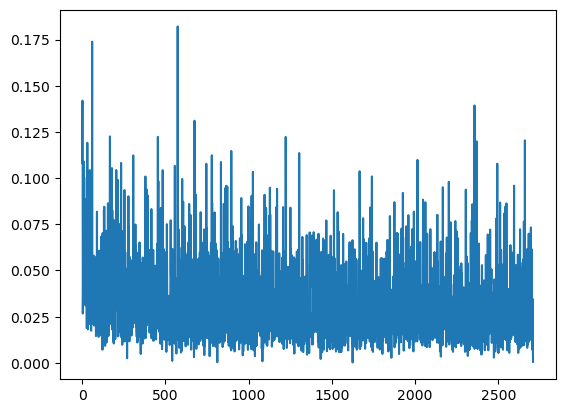

In [8]:
for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):

        batch = batch.to(device)
        encoded = musicldm_pipe.vae.encode(batch)
        # latents_real = 0.18215 * encoded.latent_dist.mean
        latents_real = 1 / musicldm_pipe.vae.config.scaling_factor * encoded.latent_dist.mean
        audio_features = clap_model.get_audio_features(batch)
        noise = torch.randn(latents_real.shape).to(latents_real.device)
        bs = batch.shape[0]
        del batch

        # Sample a random timestep for each image
        timesteps = torch.randint(0, musicldm_pipe.scheduler.num_train_timesteps, (bs,), device=latents_real.device,).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process) --> we are in the training!
        noisy_latents = musicldm_pipe.scheduler.add_noise(latents_real, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = musicldm_pipe.unet(
            noisy_latents,
            timesteps,
            encoder_hidden_states=None,
            class_labels=audio_features,
            cross_attention_kwargs=None,
            return_dict=False,
        )[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(
            noise_pred, noise
        )  

        # Store for later plotting
        train_losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch} average loss: {sum(train_losses[-len(train_dataloader):])/len(train_dataloader)}")

# Plot the loss curve:
plt.plot(train_losses)

## Inference

In [9]:
for step, batch in (enumerate(val_dataloader)):
    batch = batch.to(device)
    real_audio_val = batch[0]
    audio_features_val = clap_model.get_audio_features(real_audio_val.unsqueeze(0))
    break

In [10]:
real_audio_val.shape, audio_features_val.shape

(torch.Size([1, 1001, 64]), torch.Size([1, 512]))

In [11]:
musicldm_pipe.scheduler.set_timesteps(num_inference_steps=50, device=device)
timesteps = musicldm_pipe.scheduler.timesteps
print(timesteps)

tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1], device='cuda:4')


In [12]:
num_channels_latents = musicldm_pipe.unet.config.in_channels
latents = musicldm_pipe.prepare_latents(
    1,  # 1 = batch_size  --> da moltiplicare se num_waveforms_per_prompt > 1
    num_channels_latents,
    1000,  # height
    torch.float32,
    torch.device(device),
    generator=torch.Generator(device=device).manual_seed(42),
    latents=None,
)

In [13]:
latents.shape

torch.Size([1, 8, 250, 16])

In [14]:
num_inference_steps = 50
do_classifier_free_guidance = False
cross_attention_kwargs = None
guidance_scale = 2.0
callback = None
callback_steps = 1
extra_step_kwargs= {}
extra_step_kwargs["eta"] = 0.0
extra_step_kwargs["generator"] = torch.Generator(device=device).manual_seed(42)

In [15]:
num_warmup_steps = len(timesteps) - num_inference_steps * musicldm_pipe.scheduler.order
with musicldm_pipe.progress_bar(total=num_inference_steps) as progress_bar:
    for i, t in enumerate(timesteps):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = musicldm_pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred_eval = musicldm_pipe.unet(
            latent_model_input,
            t,
            encoder_hidden_states=None,
            class_labels=audio_features_val,
            cross_attention_kwargs=cross_attention_kwargs,
            return_dict=False,
        )[0]

        # perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred_eval.chunk(2)
            noise_pred_eval = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = musicldm_pipe.scheduler.step(noise_pred_eval, t, latents, **extra_step_kwargs).prev_sample

        # call the callback, if provided
        if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % musicldm_pipe.scheduler.order == 0):
            progress_bar.update()
            if callback is not None and i % callback_steps == 0:
                step_idx = i // getattr(musicldm_pipe.scheduler, "order", 1)
                callback(step_idx, t, latents)

100%|██████████| 50/50 [00:02<00:00, 19.08it/s]


In [16]:
output_type = "np"
if not output_type == "latent":
    latents = 1 / musicldm_pipe.vae.config.scaling_factor * latents
    mel_spectrogram = musicldm_pipe.vae.decode(latents).sample

In [17]:
audio_length_in_s = 10.0
original_waveform_length = int(audio_length_in_s * musicldm_pipe.vocoder.config.sampling_rate)
audio = musicldm_pipe.mel_spectrogram_to_waveform(mel_spectrogram.to(device=device))
audio = audio[:, :original_waveform_length]

In [18]:
if output_type == "np":
    audio = audio.detach().numpy()

audio_pipe = AudioPipelineOutput(audios=audio)

In [19]:
audio_pipe

AudioPipelineOutput(audios=array([[0.01368677, 0.01520703, 0.01606056, ..., 0.04022197, 0.03167707,
        0.02448873]], dtype=float32))

In [27]:
from IPython.display import Audio

Audio(audio_pipe[0], rate=16000)